# Recipe Site Traffic Prediction

#### Problem statement:
The marketing department selects a recipe each day to post on the homepage of the company's website. They have noticed that traffic to the rest of the website increases by as much as 40% if they pick a popular recipe. Since high traffic leads to more subscriptions to the company's services, they want to maximize traffic to their website.
Currently, they don't know how to determine whether a recipe will be popular, so they want a reliable solution that can select popular recipes at least 80% of the time.

## Data Validation and Data Cleaning

This data set has 947 rows and 8 columns. I have validated all variables and made the following changes:

- recipe: Numeric, unique ID, no missing values. Removed from the dataset.
- calories: Numeric, 52 missing values.
- carbohydrate: Numeric, 52 missing values.
- sugar: Numeric, 52 missing values.
- protein: Numeric, 52 missing values.
- category: Object, no missing values, 11 unique values. 'Chicken Breast' converted to 'Chicken'. 10 unique categories remained, just as described.
- servings: Object, no missig values. Cleaned 3 records with ' as a snack'.
- high_traffic: Object, 373 missing values representing not High traffic recipes. Column mapped as: missig values(not high traffic recipes) - 0, 'High'(high traffic recipes) - 1.

Missing values in column 'calories', 'carbohydrate', 'sugar' and 'protein' are correlated and therefore records with missing data are dropped from the dataset.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [22]:
df = pd.read_csv('../data/recipe_site_traffic.csv')

In [24]:
df.head()

,recipe,calories,carbohydrate,sugar,protein,category,servings,high_traffic
0,1,NaN,NaN,NaN,NaN,Pork,6,High
1,2,35.48,38.56,0.66,0.92,Potato,4,High
2,3,914.28,42.68,3.09,2.88,Breakfast,1,NaN
3,4,97.03,30.56,38.63,0.02,Beverages,4,High
4,5,27.05,1.85,0.80,0.53,Beverages,4,NaN


In [25]:
print(f"Number of rows: {df.shape[0]}\nNumber of columns: {df.shape[1]}")

Number of rows: 947
Number of columns: 8


### Checking missing values and data types

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 947 entries, 0 to 946
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   recipe        947 non-null    int64  
 1   calories      895 non-null    float64
 2   carbohydrate  895 non-null    float64
 3   sugar         895 non-null    float64
 4   protein       895 non-null    float64
 5   category      947 non-null    object 
 6   servings      947 non-null    object 
 7   high_traffic  574 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 59.3+ KB


### Checking statistics of numerical columns

In [27]:
df.describe()

,recipe,calories,carbohydrate,sugar,protein
count,947.000000,895.000000,895.000000,895.000000,895.000000
mean,474.000000,435.939196,35.069676,9.046547,24.149296
std,273.519652,453.020997,43.949032,14.679176,36.369739
min,1.000000,0.140000,0.030000,0.010000,0.000000
25%,237.500000,110.430000,8.375000,1.690000,3.195000
50%,474.000000,288.550000,21.480000,4.550000,10.800000
75%,710.500000,597.650000,44.965000,9.800000,30.200000
max,947.000000,3633.160000,530.420000,148.750000,363.360000


In [28]:
df['recipe'].value_counts().max()

np.int64(1)

There are no negative values. Scales are very different. Column 'recipe' is a unique id, can be dropped.

### Checking missing values

Text(0, 0.5, 'Row number')

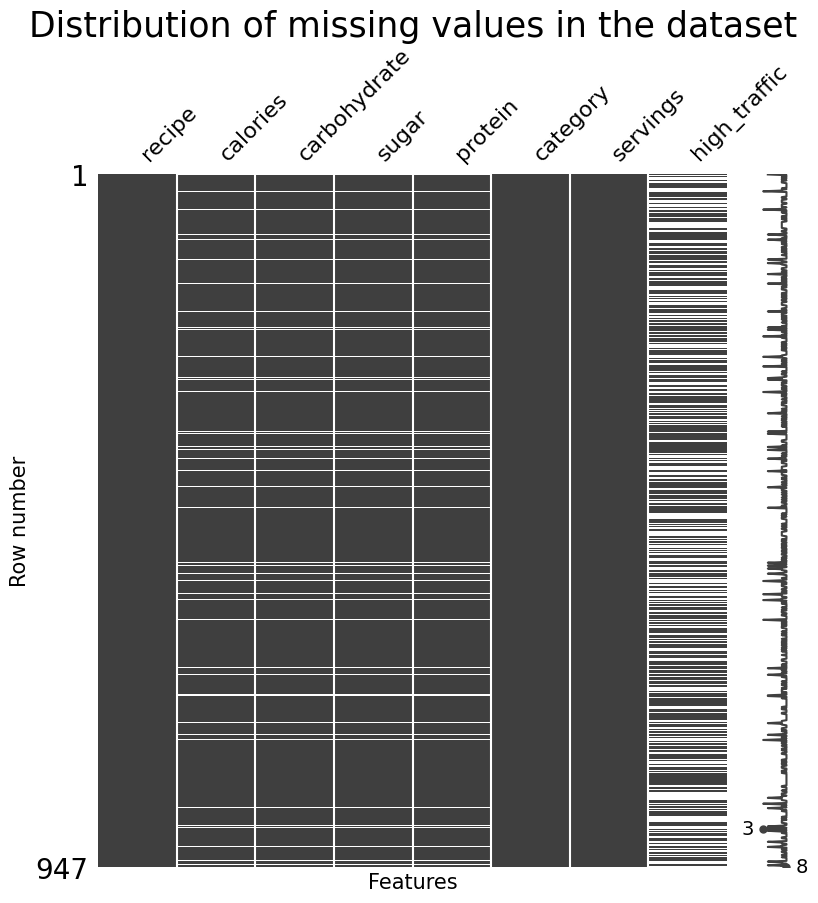

In [29]:
msno.matrix(df, figsize=(9,9))
plt.title('Distribution of missing values in the dataset', fontsize=25)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Row number', fontsize=15)

In [30]:
df.isna().sum()

recipe            0
calories         52
carbohydrate     52
sugar            52
protein          52
category          0
servings          0
high_traffic    373
dtype: int64

In [31]:
df['high_traffic'].value_counts(dropna=False)

high_traffic
High    574
NaN     373
Name: count, dtype: int64

Missing values are correlated and therefore can be dropped but missing values in 'high_traffic' represent Low traffic, these must be properly represented.

#### Checking categories in categorical columns

In [32]:
cat_features = df.select_dtypes(include='object').columns.tolist()

for col in cat_features:
    print(f"Categories in column {col}")
    print(df[col].unique().tolist())
    print("\n")

Categories in column category
['Pork', 'Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken Breast', 'Lunch/Snacks', 'Chicken', 'Vegetable', 'Meat', 'Dessert']


Categories in column servings
['6', '4', '1', '2', '4 as a snack', '6 as a snack']


Categories in column high_traffic
['High', nan]




### Data Cleaning

In [33]:
df.drop('recipe', axis=1, inplace=True)

df.loc[df['category']=='Chicken Breast', 'category'] = 'Chicken'

df['servings'] = df['servings'].str.strip(' as a snack')

traffic_dict = {'High':1, np.nan:0}
df['high_traffic'] = df['high_traffic'].map(traffic_dict)

#dropping lines with missing values
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

#### Checking categories in categorical columns after cleaning

In [34]:
cat_features = df.select_dtypes(include='object').columns.tolist()

for col in cat_features:
    print(f"Categories in column {col}")
    print(df[col].unique().tolist())
    print("\n")

Categories in column category
['Potato', 'Breakfast', 'Beverages', 'One Dish Meal', 'Chicken', 'Lunch/Snacks', 'Pork', 'Vegetable', 'Meat', 'Dessert']


Categories in column servings
['4', '1', '2', '6']




### Checking target feature

In [35]:
df['high_traffic'].value_counts(normalize=True)

high_traffic
1    0.597765
0    0.402235
Name: proportion, dtype: float64

Dataset is mildly imbalanced

## Data visualization

In [45]:
num_features = df.select_dtypes(include='number').columns.tolist()[:-1] # excluding target feature
cat_features = df.select_dtypes(include='object').columns.tolist()

print(f"Numerical features: {num_features}")
print(f"Categorical features: {cat_features}")

Numerical features: ['calories', 'carbohydrate', 'sugar', 'protein']
Categorical features: ['category', 'servings']


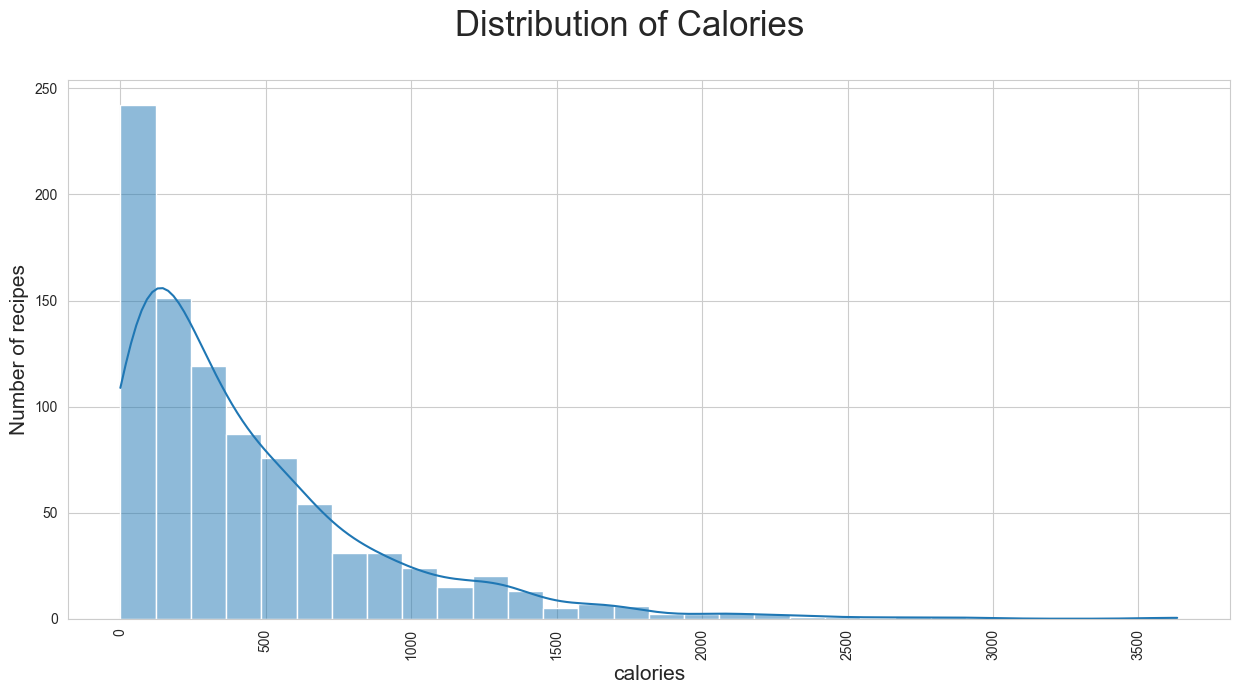

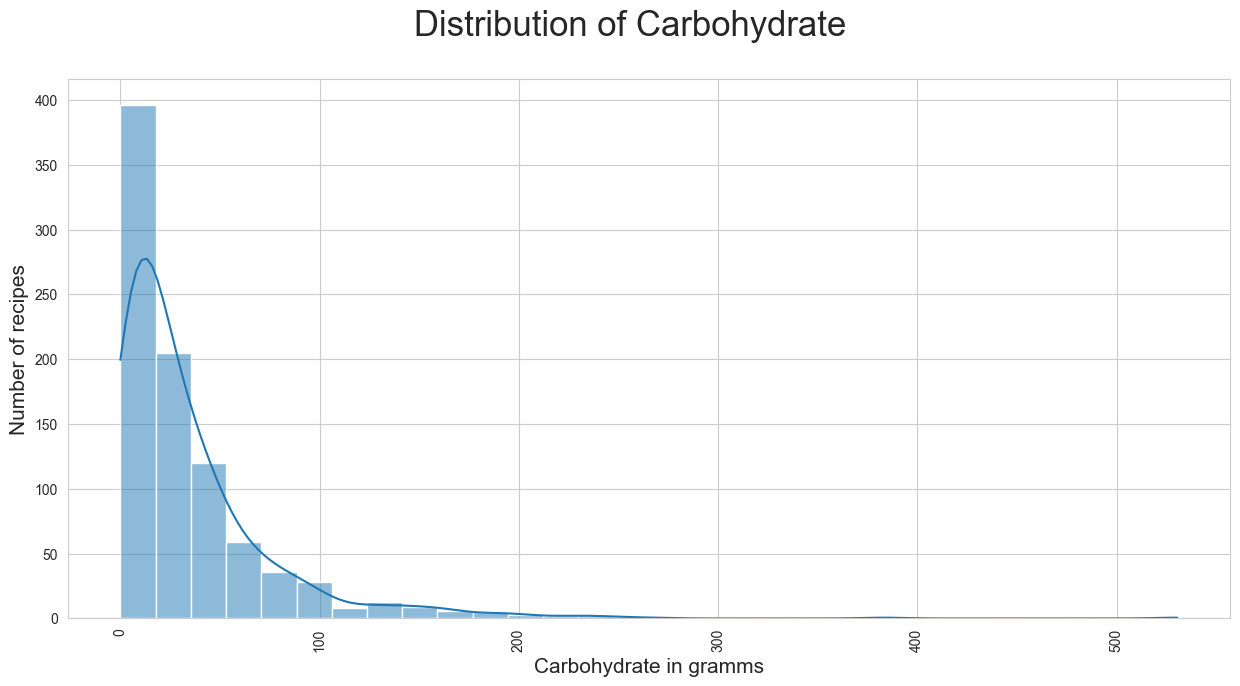

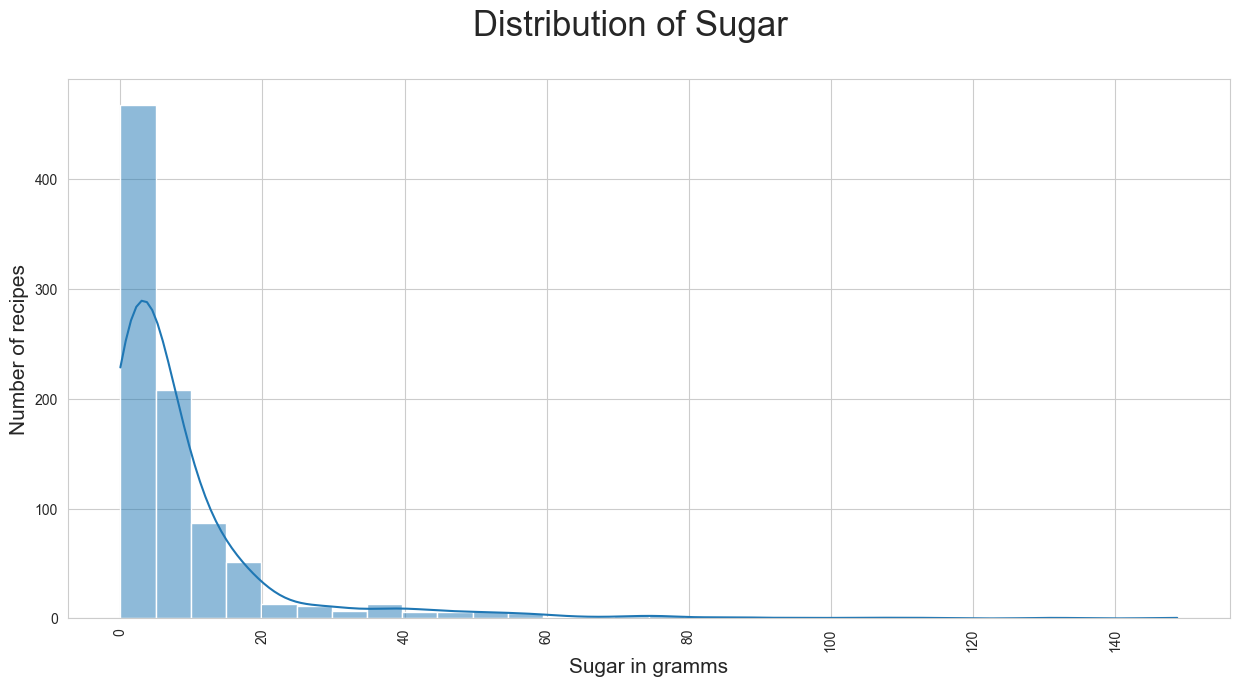

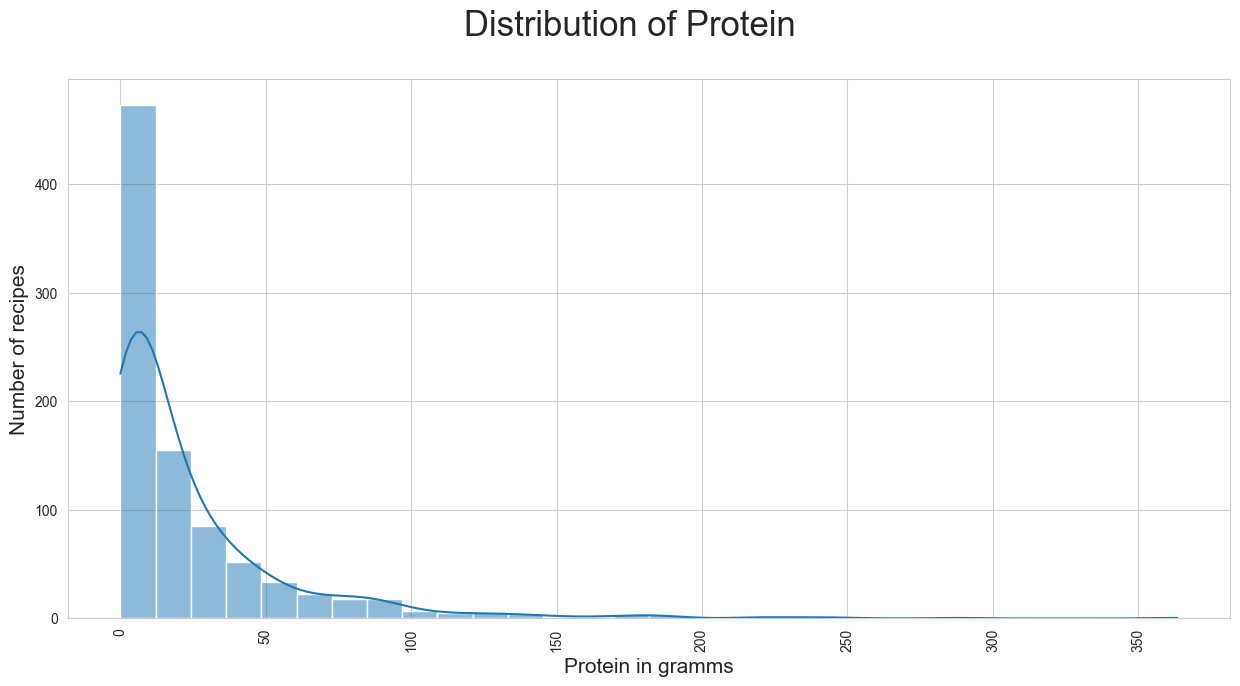

In [38]:
sns.set_style('whitegrid')
sns.color_palette('colorblind')

for num in num_features:
    fig, ax = plt.subplots(figsize=(15, 7))
    sns.histplot(df[num], kde=True, bins=30, ax=ax)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    if num != 'calories':
        ax.set_xlabel(f"{num.capitalize()} in gramms", fontsize=15)
    else:
        ax.set_xlabel(num, fontsize=15)
    ax.set_ylabel('Number of recipes', fontsize=15)
    fig.suptitle(f"Distribution of {num.capitalize()}", fontsize=25)
    plt.show()

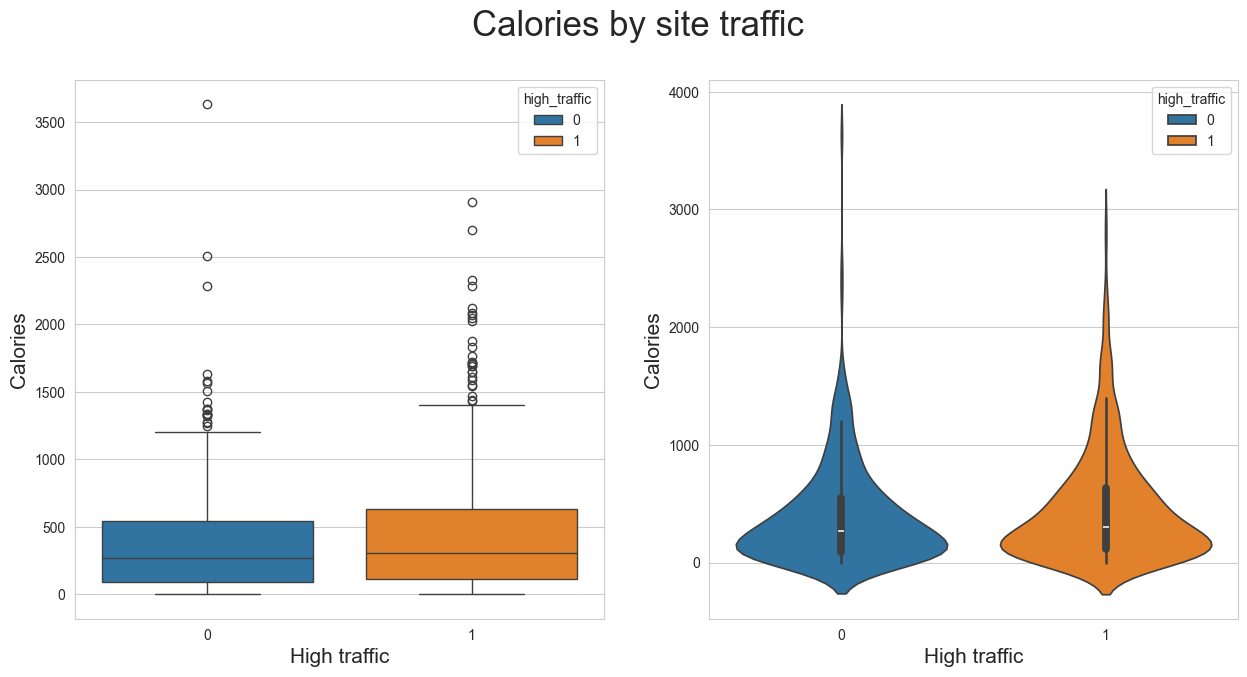

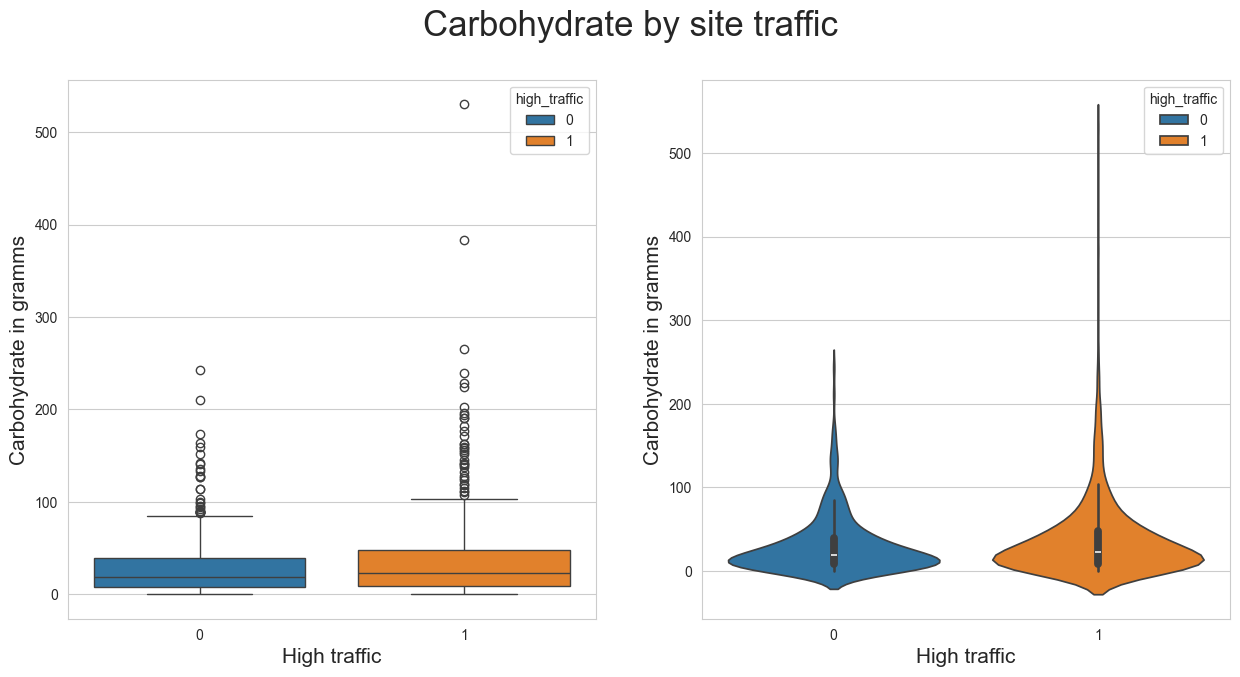

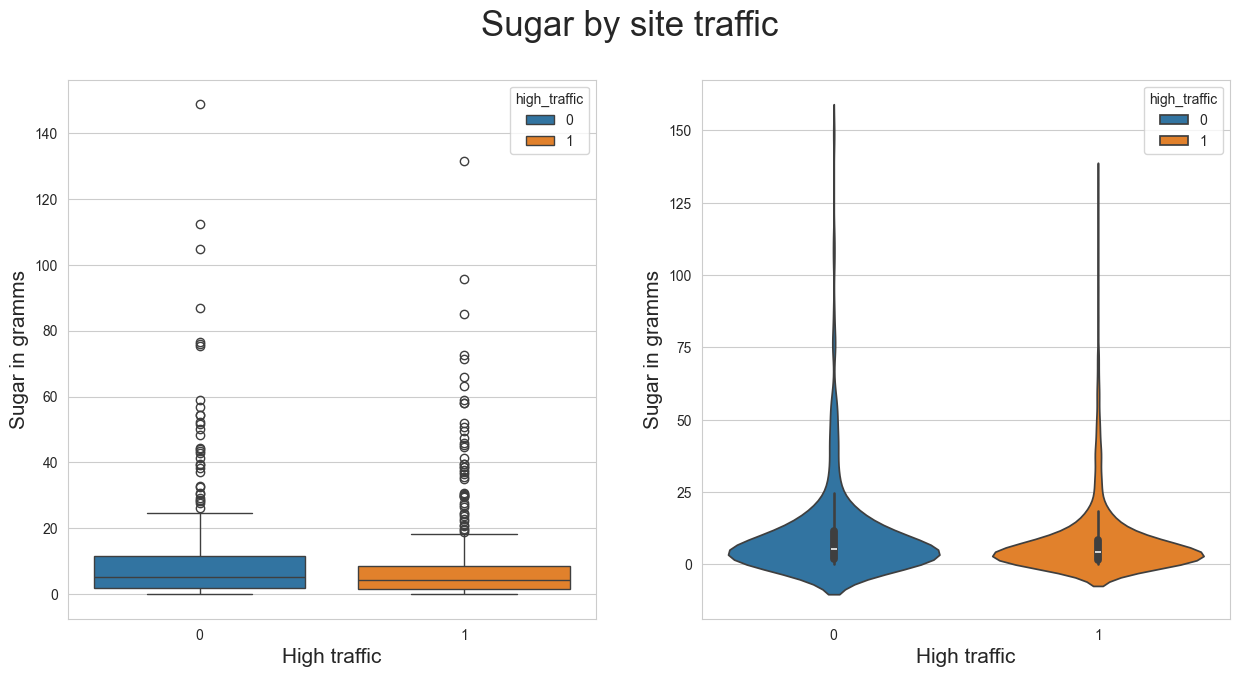

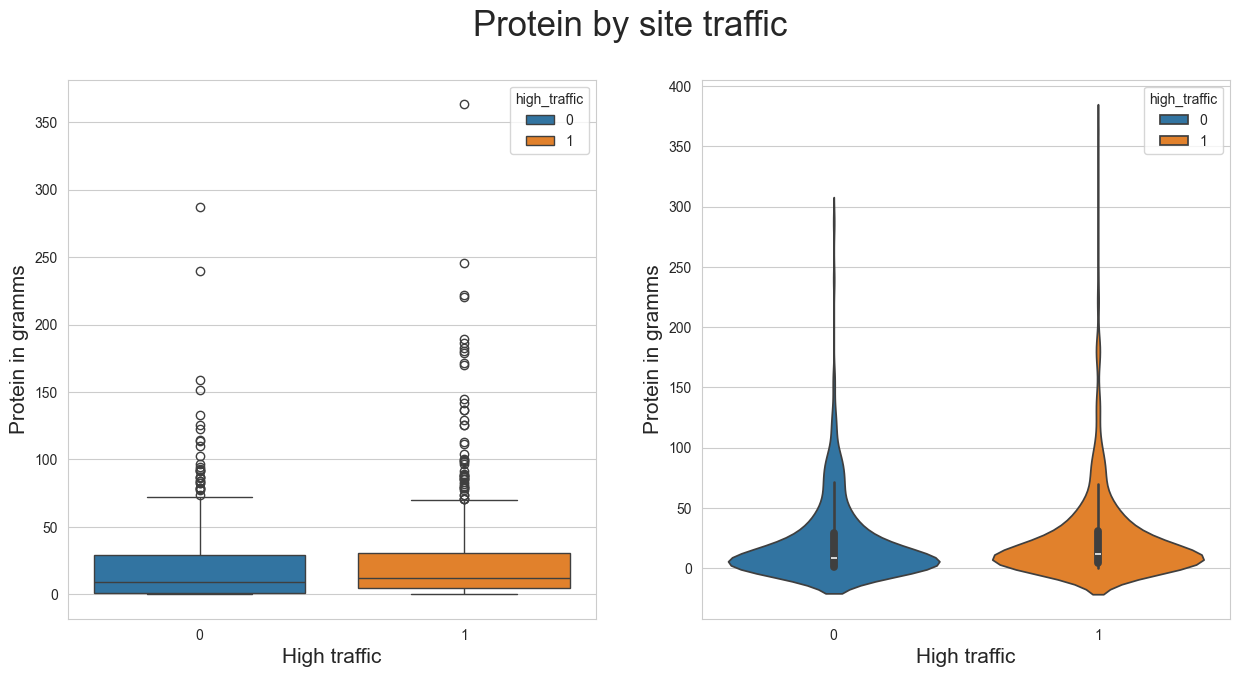

In [43]:
for num in num_features:
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    sns.boxplot(data=df, y=num, x='high_traffic', hue='high_traffic', ax=ax[0])
    sns.violinplot(data=df, y=num, x='high_traffic', hue='high_traffic', ax=ax[1])
    ax[0].tick_params(axis='x', labelsize=10)
    ax[1].tick_params(axis='x', labelsize=10)
    if num != 'calories':
        ax[0].set_ylabel(f"{num.capitalize()} in gramms", fontsize=15)
        ax[1].set_ylabel(f"{num.capitalize()} in gramms", fontsize=15)
    else:
        ax[0].set_ylabel(num.capitalize(), fontsize=15)
        ax[1].set_ylabel(num.capitalize(), fontsize=15)
    
    ax[0].set_xlabel('High traffic', fontsize=15)
    ax[1].set_xlabel('High traffic', fontsize=15)
    fig.suptitle(f"{num.capitalize()} by site traffic", fontsize=25)
    plt.show()

#### Categorical columns

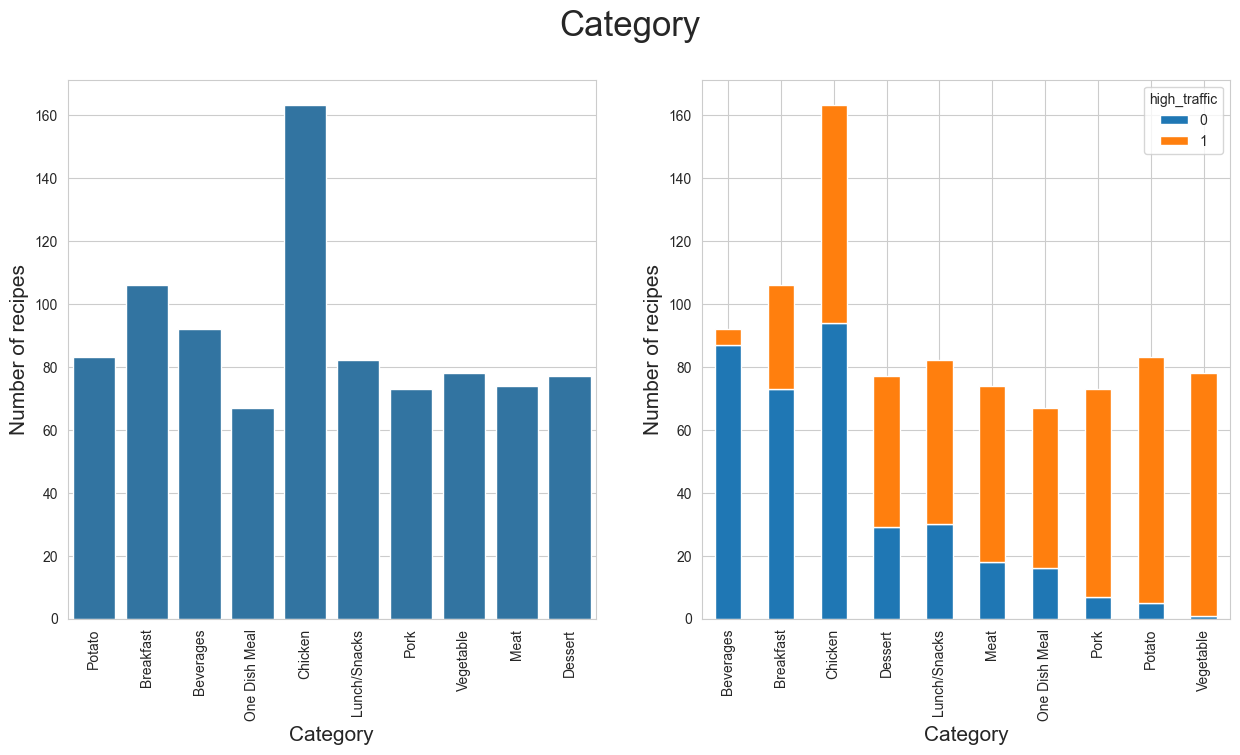

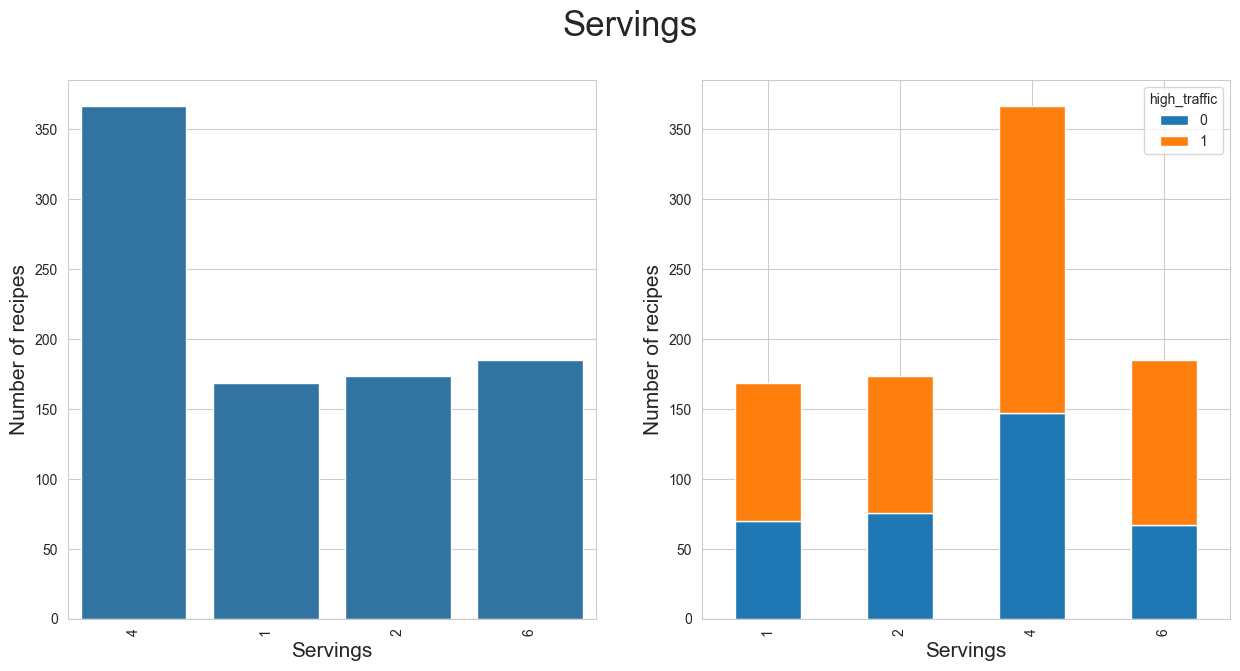

In [56]:
for cat in cat_features:
    fig, ax = plt.subplots(1, 2, figsize=(15, 7))
    sns.countplot(data=df, x=cat, ax=ax[0])
    df.groupby([cat, 'high_traffic']).size().unstack(fill_value=0).plot(kind='bar', stacked=True, ax=ax[1])
    ax[0].tick_params(axis='x', rotation=90, labelsize=10)
    ax[1].tick_params(axis='x', rotation=90, labelsize=10)
    ax[0].set_xlabel(cat.capitalize(), fontsize=15)
    ax[1].set_xlabel(cat.capitalize(), fontsize=15)
    ax[0].set_ylabel('Number of recipes', fontsize=15)
    ax[1].set_ylabel('Number of recipes', fontsize=15)
    fig.suptitle(f"{cat.capitalize()}", fontsize=25)
    plt.show()

### Correlation of numerical values

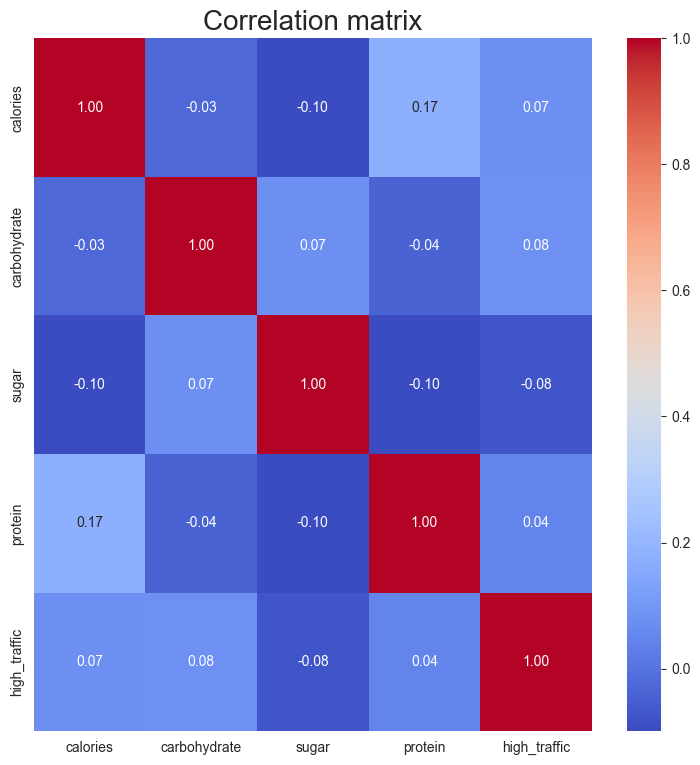

In [ ]:
plt.figure(figsize=(9,9))
sns.heatmap(data=df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation matrix', fontsize=20)
plt.show()

No significant correlation detected

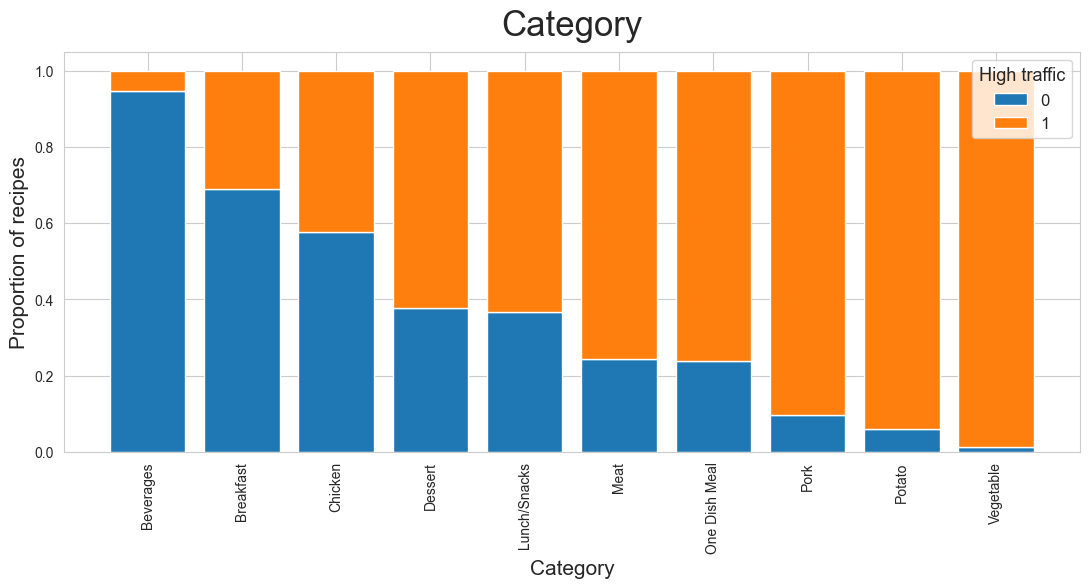

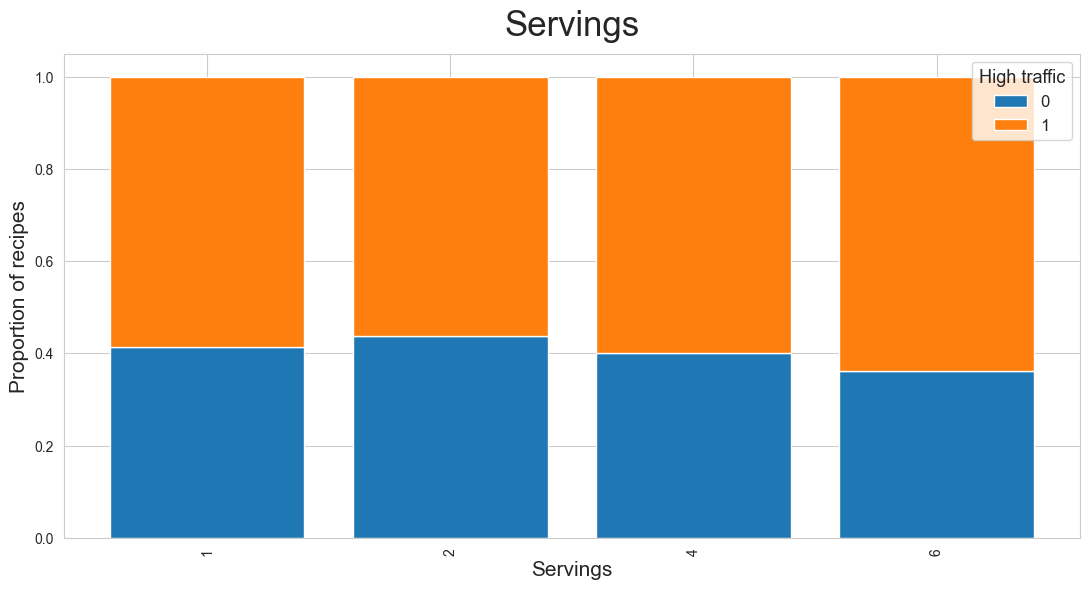

In [50]:
for cat in cat_features:
    grouped = (
        df.groupby(cat)['high_traffic']
        .value_counts(normalize=True)
        .unstack(fill_value=0)
    )

    
    fig, ax = plt.subplots(figsize=(11, 6))
    bottom = None

    for label in grouped.columns:
        ax.bar(grouped.index, grouped[label], bottom=bottom, label=str(label))
        bottom = grouped[label] if bottom is None else bottom + grouped[label]

    ax.set_title(f"{cat.capitalize()}", fontsize=25, y=1.02)
    ax.set_xlabel(cat.capitalize(), fontsize=15)
    ax.set_ylabel("Proportion of recipes", fontsize=15)
    ax.tick_params(axis='x', rotation=90, labelsize=10)
    ax.legend(title='High traffic', fontsize=12, title_fontsize=13)
    plt.tight_layout()
    plt.show()

### Distribution of target feature

C:\Users\Ricsi\AppData\Local\Temp\ipykernel_13872\141232980.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Low', 'High'])


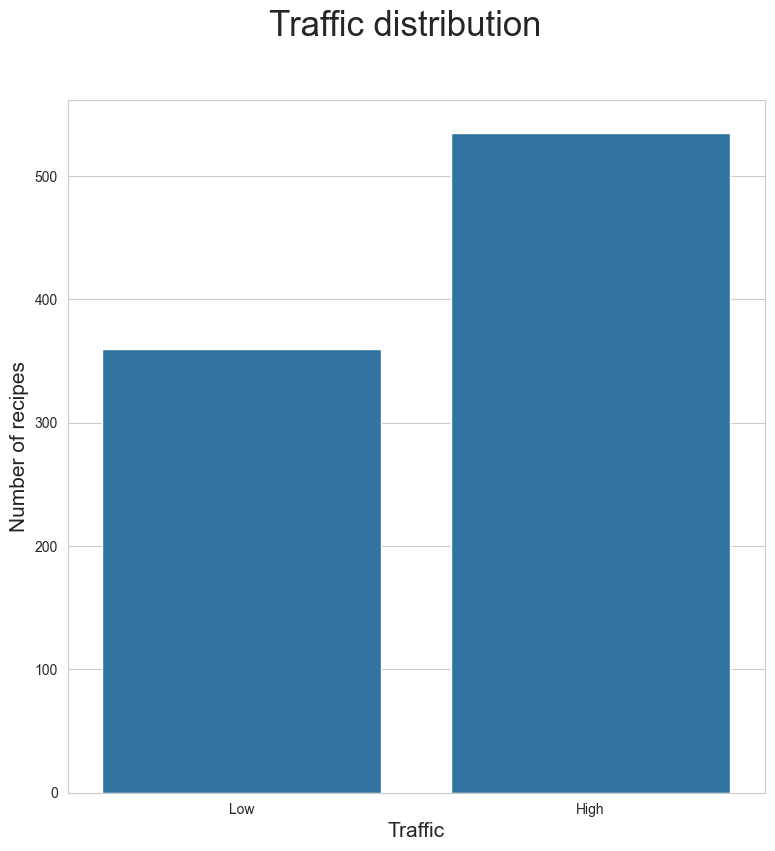

In [52]:
fig, ax = plt.subplots(figsize=(9,9))
sns.countplot(data=df, x="high_traffic", ax=ax)

ax.tick_params(axis='x', labelsize=10)
ax.set_xlabel("Traffic", fontsize=15)
ax.set_xticklabels(['Low', 'High'])
ax.set_ylabel('Number of recipes', fontsize=15)

fig.suptitle("Traffic distribution", fontsize=25)
plt.show()

## Key findings

- There is a significant spread in calories, carbohydrate, sugar and protein. 

- There are recipes with extreme values from all components but there is no correlation between extreme values and high traffic.

- There is a significant difference between the proportion of high traffic recipes among the categories.

- Posting recipes in the Beverages, Breakfast or Chicken categories are less likely to generate high traffic than recipes in other categories.

- While almost none of the recipes in the Beverages category will result in high traffic almost all recipes in the Vegetable category generated high traffic for the company.

